In [25]:
import RtKernel as ker
import RtDlr as dlr
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica", "font.size": 8})

In [26]:
beta = 20
N_max = 100
delta_t = 0.1
upper_cutoff = 600
phi = np.pi / 4
times = ker.set_time_grid(
    N_max=N_max, delta_t=delta_t
)  # time grid up to maximal time used

params = {
    "m": None,  # to be updated for each computation
    "n": None,  # to be updated for each computation
    "N_max": None,
    "delta_t": None,
    "beta": beta,
    "upper_cutoff": upper_cutoff,
    "times": times,
    "h": None,  # to be updated for each computation
}  # either "N_max" and "delta_t" OR "times" needs to be specified to define the time grid. If all is specified, the argument "times" is used as time grid

In [27]:
# compute continuous integral results
cont_integral = np.array(
    [ker.cont_integral(t, beta, upper_cutoff) for t in times]
)  # array containing all values for the continuous integration result

In [33]:
# create empty array in which to store DiscrError objects
discr_errors = np.empty(shape=(0,), dtype=object)

h_vals = np.log(
    np.arange(2, 1.0, -0.05)
)  # create an array of discretization parameters h which should be explored
for i, h in enumerate(h_vals):
    # update grid parameters
    params["h"] = h
    params["m"] = int(10.0 / h)
    params["n"] = int(5.0 / h)

    # compute the DiscrError object which hold the error w.r.t. to the continous results, and all associated parameters.
    discr_error = ker.DiscrError(
        **params
    )  # generate instance of the error class which holds all parameters specifying the frequency parametrization
    discr_error.optimize(time_series_exact=cont_integral)  # optimize values for m and n

    # If error is smaller than previous error and is above machine precision, add DiscrError object to array.
    eps_current = discr_error.eps  # current error
    eps_previous = discr_errors[-1].eps if i > 1 else eps_current  # previous error
    if eps_current > eps_previous or eps_current < 1.0e-15:
        print(
            f"Either error does not shrink with decreasing h or machine precision error was reached. "
            f"Performed {i} iterations. Error = {eps_current}. Stopping the iteration."
        )
    else:
        discr_errors = np.append(
            discr_errors, discr_error
        )  # if all OK, append to array

Either error does not shrink with decreasing h or machine precision error was reached. Performed 19 iterations. Error = 7.77799051375009e-17. Stopping the iteration.


In [34]:
# compute ID and SVD
D = np.array([dlr.RtDlr(discr_error) for discr_error in discr_errors])

In [35]:
# Compute the time-integrated error between the original Green's function and the reconstructed Green's function for all values of h.
propagator_reconstr, propagator_errors = zip(
    *[d.reconstruct_propag(compute_error=True) for d in D]
)

In [36]:
# create arrays of data to plot
errors, m_vals, n_vals, h_vals = np.array(
    list(zip(*[[d.eps, d.m, d.n, d.h] for d in D]))
)
nbr_iterations = len(D)  # number of entries in all the arrays above

Text(0, 0.5, 'Density of frequency points')

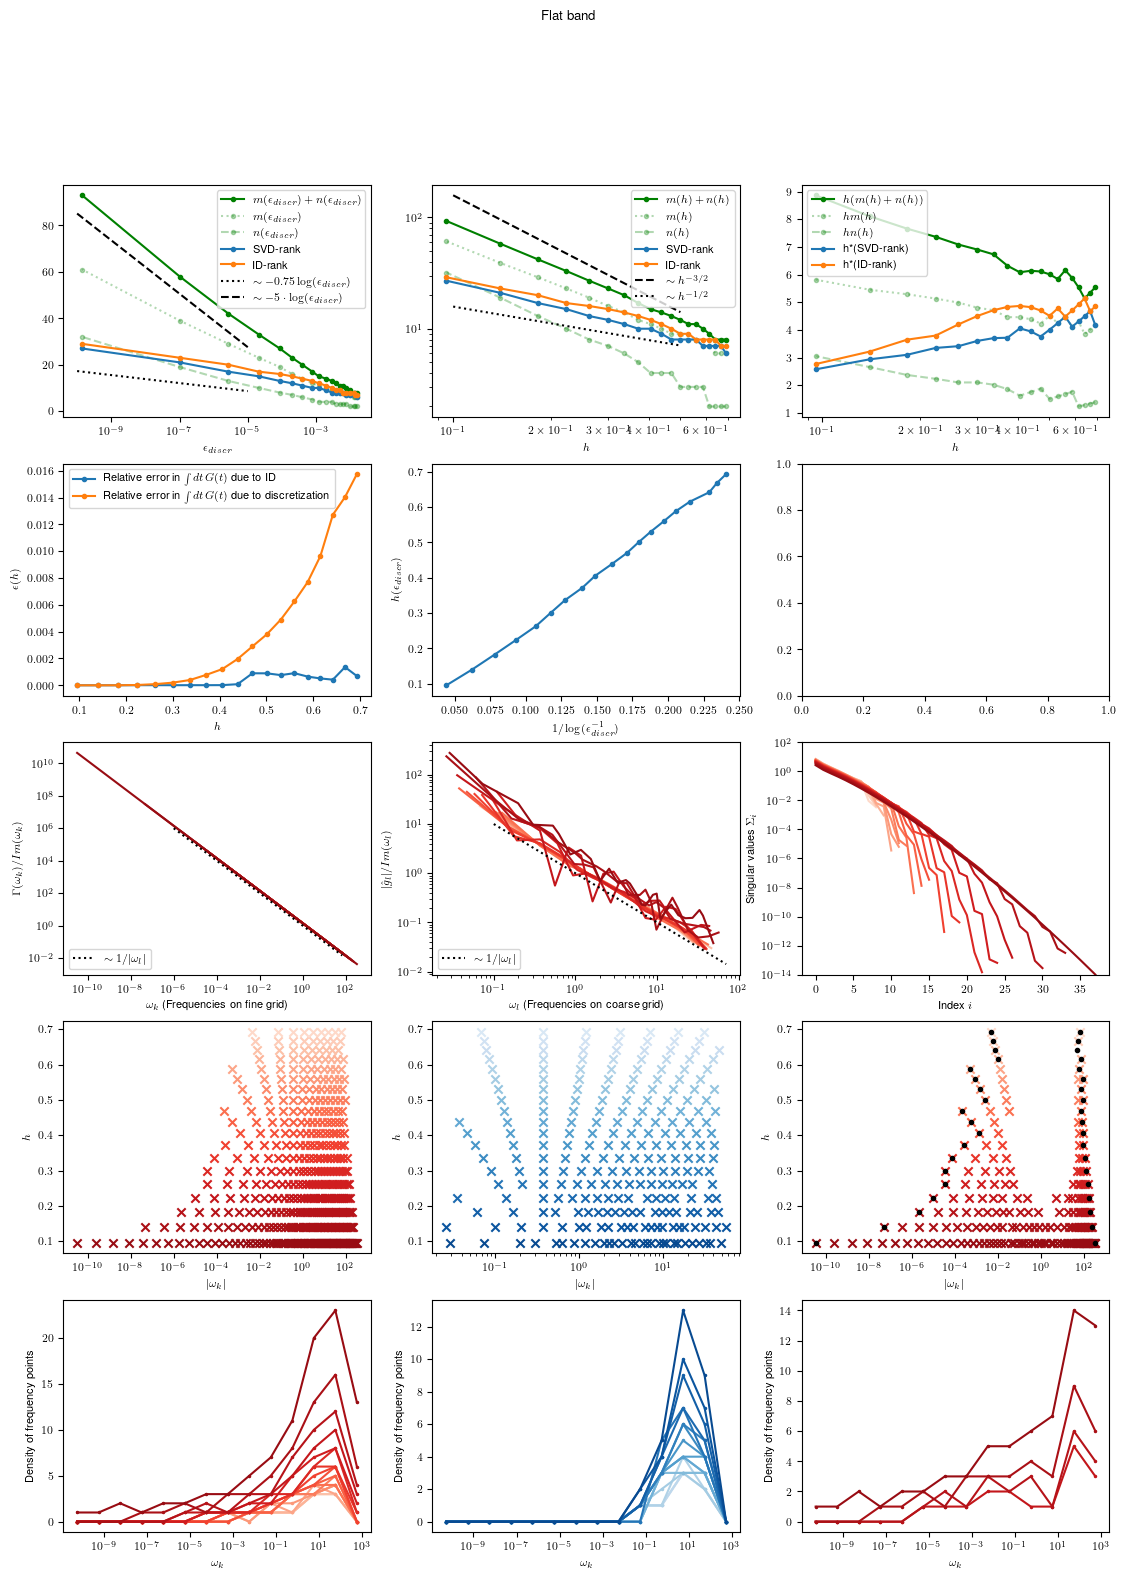

In [37]:
fig, axs = plt.subplots(5, 3, figsize=(13.5, 17.5))
fig.suptitle("Flat band")

cmaps = [plt.get_cmap("Blues"), plt.get_cmap("Reds")]
colors_blue = cmaps[0](np.linspace(0.15, 0.9, len(h_vals)))
colors_orange = cmaps[1](np.linspace(0.15, 0.9, len(h_vals)))


axs[0, 0].plot(
    errors,
    m_vals + n_vals,
    color="green",
    label=r"$m(\epsilon_{discr}) + n(\epsilon_{discr})$",
    marker="o",
    linestyle="-",
    markersize=3,
)
axs[0, 0].plot(
    errors,
    m_vals,
    color="green",
    label=r"$m(\epsilon_{discr})$",
    alpha=0.3,
    linestyle="dotted",
    marker="o",
    markersize=3,
)
axs[0, 0].plot(
    errors,
    n_vals,
    color="green",
    label=r"$n(\epsilon_{discr})$",
    alpha=0.3,
    linestyle="dashed",
    marker="o",
    markersize=3,
)
num_sing_vals = np.array([d.num_singular_values_above_threshold for d in D])
axs[0, 0].plot(
    errors, num_sing_vals, label="SVD-rank", marker="o", linestyle="-", markersize=3
)
ID_rank = np.array([d.ID_rank for d in D])
axs[0, 0].plot(
    errors, ID_rank, label="ID-rank", marker="o", linestyle="-", markersize=3
)
err_space = np.linspace(1.0e-10, 1.0e-5)
axs[0, 0].plot(
    err_space,
    -0.75 * np.log(err_space),
    color="black",
    linestyle="dotted",
    label=r"$\sim -0.75\log(\epsilon_{discr})$",
)
axs[0, 0].plot(
    err_space,
    -5 * np.log(err_space) - 30,
    color="black",
    linestyle="dashed",
    label=r"$\sim -5\cdot\log(\epsilon_{discr})$",
)
axs[0, 0].set_xlabel(r"$\epsilon_{discr}$")
axs[0, 0].legend()
axs[0, 0].set_xscale("log")

axs[0, 1].plot(
    h_vals,
    m_vals + n_vals,
    color="green",
    label=r"$m(h) + n(h)$",
    marker="o",
    linestyle="-",
    markersize=3,
)
axs[0, 1].plot(
    h_vals,
    m_vals,
    color="green",
    label=r"$m(h)$",
    alpha=0.3,
    linestyle="dotted",
    marker="o",
    markersize=3,
)
axs[0, 1].plot(
    h_vals,
    n_vals,
    color="green",
    label=r"$n(h)$",
    alpha=0.3,
    linestyle="dashed",
    marker="o",
    markersize=3,
)
num_sing_vals = np.array([d.num_singular_values_above_threshold for d in D])
axs[0, 1].plot(
    h_vals, num_sing_vals, label="SVD-rank", marker="o", linestyle="-", markersize=3
)
ID_rank = np.array([d.ID_rank for d in D])
axs[0, 1].plot(
    h_vals, ID_rank, label="ID-rank", marker="o", linestyle="-", markersize=3
)
axs[0, 1].legend()
axs[0, 1].set_xlabel(r"$h$")
axs[0, 1].set_xscale("log")
axs[0, 1].set_yscale("log")
axs[0, 1].plot(
    np.logspace(-1, -0.3),
    1 / np.logspace(-1, -0.3) ** (3.0 / 2) * 5,
    color="black",
    linestyle="dashed",
    label=r"$\sim h^{-3/2}$",
)
axs[0, 1].plot(
    np.logspace(-1, -0.3),
    1 / np.sqrt(np.logspace(-1, -0.3)) * 5,
    color="black",
    linestyle="dotted",
    label=r"$\sim h^{-1/2}$",
)
axs[0, 1].legend()

axs[0, 2].plot(
    h_vals,
    h_vals * (m_vals + n_vals),
    color="green",
    label=r"$h(m(h) + n(h))$",
    marker="o",
    linestyle="-",
    markersize=3,
)
axs[0, 2].plot(
    h_vals,
    h_vals * m_vals,
    color="green",
    label=r"$h m(h)$",
    alpha=0.3,
    linestyle="dotted",
    marker="o",
    markersize=3,
)
axs[0, 2].plot(
    h_vals,
    h_vals * n_vals,
    color="green",
    label=r"$hn(h)$",
    alpha=0.3,
    linestyle="dashed",
    marker="o",
    markersize=3,
)
num_sing_vals = np.array([d.num_singular_values_above_threshold for d in D])
axs[0, 2].plot(
    h_vals,
    h_vals * num_sing_vals,
    label="h*(SVD-rank)",
    marker="o",
    linestyle="-",
    markersize=3,
)
ID_rank = np.array([d.ID_rank for d in D])
axs[0, 2].plot(
    h_vals,
    h_vals * ID_rank,
    label="h*(ID-rank)",
    marker="o",
    linestyle="-",
    markersize=3,
)
axs[0, 2].set_xlabel(r"$h$")
axs[0, 2].legend()
axs[0, 2].set_xscale("log")


axs[1, 0].plot(
    h_vals,
    propagator_errors,
    label="Relative error in " + r"$\int dt\, G(t)$" + " due to ID",
    marker="o",
    linestyle="-",
    markersize=3,
)
axs[1, 0].plot(
    h_vals,
    errors,
    label="Relative error in " + r"$\int dt\,G(t)$" + " due to discretization",
    marker="o",
    linestyle="-",
    markersize=3,
)
axs[1, 0].set_xlabel(r"$h$")
axs[1, 0].set_ylabel(r"$\epsilon(h)$")
# axs[1,0].set_yscale('log')
# axs[1,0].set_xscale('log')
axs[1, 0].legend()


axs[1, 1].plot(1 / np.log(1 / errors), h_vals, marker="o", linestyle="-", markersize=3)
axs[1, 1].set_xlabel(r"$1/\log(\epsilon_{discr}^{-1})$")
axs[1, 1].set_ylabel(r"$h(\epsilon_{discr})$")
# axs[1,1].legend()


for c, d in enumerate(D):
    fine_grid = d.fine_grid
    axs[2, 0].plot(
        fine_grid, 1.0 / np.imag(fine_grid * np.exp(1.0j * phi)), color=colors_orange[c]
    )

axs[2, 0].set_ylabel(r"$\Gamma(\omega_k) / Im(\omega_k)$")
axs[2, 0].set_xlabel(r"$\omega_k$" + " (Frequencies on fine grid)")
axs[2, 0].set_yscale("log")
axs[2, 0].set_xscale("log")
axs[2, 0].plot(
    np.linspace(1.0e-6, 70),
    1 / np.linspace(1.0e-6, 70),
    linestyle="dotted",
    label=r"$\sim 1/|\omega_l|$",
    color="black",
)
axs[2, 0].legend(loc="lower left")


for c, d in enumerate(D):
    couplings_eff = d.coupl_eff()
    coarse_grid = d.coarse_grid
    arg_sort_coarse = np.argsort(coarse_grid)
    axs[2, 1].plot(
        np.sort(coarse_grid),
        abs(couplings_eff[arg_sort_coarse])
        / np.imag(coarse_grid[arg_sort_coarse] * np.exp(1.0j * phi)),
        color=colors_orange[c],
    )

axs[2, 1].set_ylabel(r"$|\hat{g}_l| / Im(\omega_l)$")
axs[2, 1].set_xlabel(r"$\omega_l$" + " (Frequencies on coarse grid)")
axs[2, 1].set_yscale("log")
axs[2, 1].set_xscale("log")
axs[2, 1].plot(
    np.linspace(0.1, 70),
    1 / np.linspace(0.1, 70),
    linestyle="dotted",
    label=r"$\sim 1/|\omega_l|$",
    color="black",
)
axs[2, 1].legend(loc="lower left")


for c, d in enumerate(D):
    singular_values = d.singular_values
    del_sing_vals = [
        i for i, sigma in enumerate(singular_values) if abs(sigma) < 1.0e-14
    ]
    singular_values = np.delete(singular_values, del_sing_vals)
    axs[2, 2].plot(
        np.arange(len(singular_values)), singular_values, color=colors_orange[c]
    )
axs[2, 2].set_xlabel("Index " + r"$i$")
axs[2, 2].set_ylabel("Singular values " + r"$\Sigma_i$")
axs[2, 2].set_yscale("log")
axs[2, 2].set_ylim(bottom=1.0e-14, top=100)


for i, h in enumerate(h_vals):
    fine_grid = D[i].fine_grid  # fine grid at some index, here chosen to be len(D)//2
    coarse_grid = D[
        i
    ].coarse_grid  # coarse grid at some index, here chosen to be len(D)//2
    grid_diff = np.setdiff1d(fine_grid, coarse_grid)
    axs[3, 0].scatter(
        fine_grid, len(fine_grid) * [h], color=colors_orange[i], marker="x"
    )
    axs[3, 1].scatter(
        coarse_grid, len(coarse_grid) * [h], color=colors_blue[i], marker="x"
    )
    axs[3, 2].scatter(
        grid_diff,
        len(grid_diff) * [h],
        color=colors_orange[i],
        label="ID subgrid",
        marker="x",
    )
    axs[3, 2].scatter(
        [fine_grid[0], fine_grid[-1]],
        2 * [h],
        color="black",
        label="ID subgrid",
        marker=".",
    )


axs[3, 0].set_xscale("log")
axs[3, 0].set_xlabel(r"$|\omega_k|$")
axs[3, 0].set_ylabel(r"$h$")

axs[3, 1].set_xscale("log")
axs[3, 1].set_xlabel(r"$|\omega_k|$")
axs[3, 1].set_ylabel(r"$h$")

axs[3, 2].set_xscale("log")
axs[3, 2].set_xlabel(r"$|\omega_k|$")
axs[3, 2].set_ylabel(r"$h$")


for i, h in enumerate(h_vals):
    fine_grid = D[i].fine_grid  # fine grid at some index, here chosen to be len(D)//2
    coarse_grid = D[
        i
    ].coarse_grid  # coarse grid at some index, here chosen to be len(D)//2
    diff_grid = np.setdiff1d(fine_grid, coarse_grid)
    lower_lim = -11
    upper_lim = 3
    density_fine, fine_density_grid = ker.point_density(
        fine_grid, lower_lim, upper_lim, interval_spacing="log"
    )
    density_coarse, coarse_density_grid = ker.point_density(
        coarse_grid, lower_lim, upper_lim, interval_spacing="log"
    )
    density_diff, diff_density_grid = ker.point_density(
        diff_grid, lower_lim, upper_lim, interval_spacing="log"
    )
    axs[4, 0].plot(
        fine_density_grid,
        density_fine,
        marker=".",
        markersize=3,
        color=colors_orange[i],
    )
    axs[4, 1].plot(
        coarse_density_grid,
        density_coarse,
        marker=".",
        markersize=3,
        color=colors_blue[i],
    )
    if i > nbr_iterations - 5:
        axs[4, 2].plot(
            diff_density_grid,
            density_diff,
            marker=".",
            markersize=3,
            color=colors_orange[i],
        )

axs[4, 0].set_xscale("log")
axs[4, 0].set_xlabel(r"$\omega_k$")
axs[4, 0].set_ylabel("Density of frequency points")

axs[4, 1].set_xscale("log")
axs[4, 1].set_xlabel(r"$\omega_k$")
axs[4, 1].set_ylabel("Density of frequency points")

axs[4, 2].set_xscale("log")
axs[4, 2].set_xlabel(r"$\omega_k$")
axs[4, 2].set_ylabel("Density of frequency points")

# plt.savefig('./plots/overview_flatband.pdf')